# Step 3–5: Inference, Clustering, and Golden Record Merging

In [19]:
import pandas as pd
import numpy as np
import joblib
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from fuzzywuzzy import fuzz
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load model and test data
model = joblib.load('../src/trained_model.pkl')
df = pd.read_excel('../data/test_customers.xlsx')
pairs = pd.read_csv('../data/test_pairs.csv')

In [6]:
# Generate feature vectors for test pairs
model_embed = SentenceTransformer('all-MiniLM-L6-v2')
df['combo'] = df['First Name'] + ' ' + df['Email']
df['embedding'] = df['combo'].apply(lambda x: model_embed.encode(x))
tfidf = TfidfVectorizer().fit(df['combo'])
tfidf_matrix = tfidf.transform(df['combo'])

features = []
for row in pairs.itertuples():
    i, j = int(row.record1_index), int(row.record2_index)
    r1, r2 = df.iloc[i], df.iloc[j]
    features.append({
        #'name_sim': fuzz.token_sort_ratio(r1['First Name'], r2['First Name']),
        #'last_name_sim': fuzz.token_sort_ratio(r1['Last Name'], r2['Last Name']),
        #'email_sim': fuzz.token_sort_ratio(r1['Email'], r2['Email']),
        #'birthdate_diff': abs(pd.to_datetime(r1['Birthdate']) - pd.to_datetime(r2['Birthdate'])).days,
        'tfidf_sim': cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0],
        'embedding_sim': cosine_similarity([r1['embedding']], [r2['embedding']])[0][0],
        #'gender_match': int(r1['Gender'] == r2['Gender']),
        #'phone_match': int(r1['Phone'] == r2['Phone']),
        #'insurance_match': int(r1['Insurance No'] == r2['Insurance No'])
    })
features_df = pd.DataFrame(features)
proba = model.predict_proba(features_df)[:, 1]
pairs['predicted_proba'] = proba
pairs.to_csv('../output/pair_scores.csv', index=False)
pairs.head()

,record1_index,record2_index,record1_id,record2_id,is_duplicate,predicted_proba
0,0,1,0,0,1,0.999866
1,0,2,0,0,1,0.998806
2,3,4,1,1,1,0.999866
3,3,5,1,1,1,0.988981
4,6,7,2,2,1,0.999866


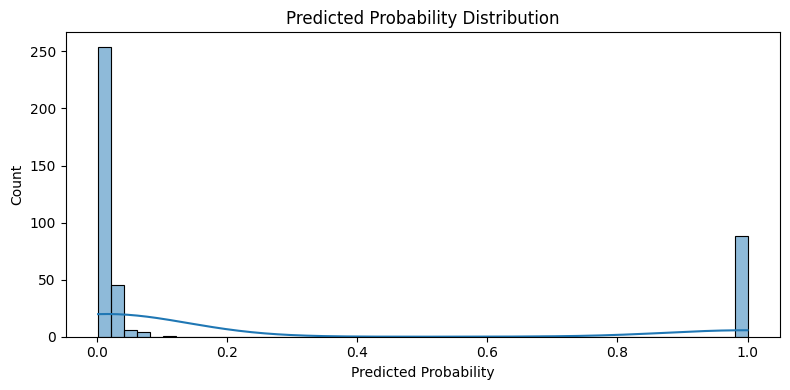

In [7]:
# Visualize prediction distribution
plt.figure(figsize=(8, 4))
sns.histplot(pairs['predicted_proba'], bins=50, kde=True)
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Probability')
plt.tight_layout()
plt.show()

In [8]:
# Clustering via graph
threshold = 0.85
G = nx.Graph()
G.add_nodes_from(df.index)
for row in pairs.itertuples():
    if row.predicted_proba >= threshold:
        G.add_edge(row.record1_index, row.record2_index)
components = list(nx.connected_components(G))
cluster_map = {}
for cid, nodes in enumerate(components):
    for node in nodes:
        cluster_map[node] = cid
df['cluster_id'] = df.index.map(cluster_map).fillna(-1).astype(int)
df[['cluster_id']].to_csv('../output/cluster_mapping.csv', index=False)
df['cluster_id'].value_counts().head()

cluster_id
0    3
1    3
2    3
3    3
4    3
Name: count, dtype: int64

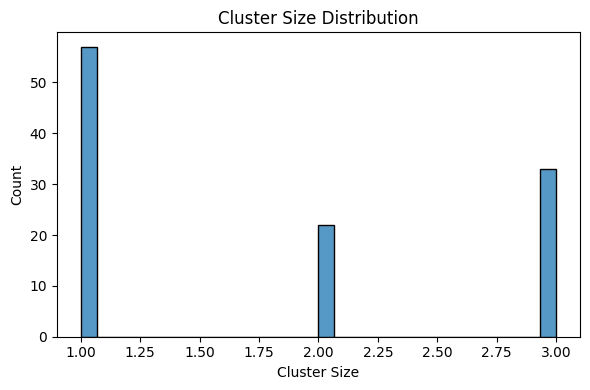

In [9]:
# Visualize cluster sizes
plt.figure(figsize=(6, 4))
sns.histplot(df['cluster_id'].value_counts(), bins=30)
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster Size')
plt.tight_layout()
plt.show()

In [ ]:
# Merge clusters into golden records
def merge_group(group):
    merged = {}
    for col in ['First Name', 'Last Name', 'Email', 'Phone', 'Gender', 'City', 'Country']:
        merged[col] = group[col].mode().iloc[0] if not group[col].mode().empty else ''
    merged['Birthdate'] = group['Birthdate'].min()
    merged['Notes'] = ' '.join(group['Notes'].dropna().astype(str))[:500]
    merged['cluster_id'] = group['cluster_id'].iloc[0]
    return pd.Series(merged)

golden = df[df['cluster_id'] >= 0].groupby('cluster_id').apply(merge_group).reset_index(drop=True)
golden.head()

,First Name,Last Name,Email,Phone,Gender,City,Country,Birthdate,Notes,cluster_id
0,Richard,Gonzalez,deanmiller@example.net,(588)419-7369x9356,Female,South Aprilborough,New Caledonia,1956-07-16,Democratic TV claim social. Democratic TV clai...,0
1,Tonya,Raymond,rodriguezgeorge@example.net,(216)512-4906x52863,Male,New Luis,Luxembourg,1989-04-21,Bring state control authority explain. Bring s...,1
2,Jennifer,Ross,melissa34@example.org,001-653-736-4717x641,Female,Adamstad,Puerto Rico,1974-08-02,Smile end indicate sell. Smile end indicate se...,2
3,Kaitlyn,Stevenson,james01@example.com,(442)929-0600x58384,Male,Whitefort,Montserrat,1976-03-21,Wonder mother young model. Wonder mother young...,3
4,Brian,Hampton,washingtonjoshua@example.net,(418)338-2581x122,Male,East Nicholasville,Slovenia,1959-12-30,Run own three theory claim three. Run own thre...,4


In [11]:
# Summary statistics
n_total = len(df)
n_clustered = (df["cluster_id"] >= 0).sum()
n_clusters = df["cluster_id"].nunique()
n_pairs = len(pairs)
n_links_high_conf = (pairs["predicted_proba"] >= 0.85).sum()
n_links_low_conf = ((pairs["predicted_proba"] < 0.85) & (pairs["predicted_proba"] > 0.5)).sum()

In [12]:
# List of low-confidence pairs
low_confidence_pairs = pairs[(pairs["predicted_proba"] > 0.5) & (pairs["predicted_proba"] < 0.85)].copy()
low_confidence_pairs["record1_name"] = df.loc[low_confidence_pairs["record1_index"], "First Name"].values
low_confidence_pairs["record2_name"] = df.loc[low_confidence_pairs["record2_index"], "First Name"].values
low_confidence_pairs["record1_email"] = df.loc[low_confidence_pairs["record1_index"], "Email"].values
low_confidence_pairs["record2_email"] = df.loc[low_confidence_pairs["record2_index"], "Email"].values

In [15]:
# Save to Excel
with pd.ExcelWriter("../output/golden_record_report.xlsx", engine="xlsxwriter") as writer:
    golden.to_excel(writer, sheet_name="Golden Records", index=False)
    df.to_excel(writer, sheet_name="All Records + Cluster", index=False)
    pairs.to_excel(writer, sheet_name="All Pairs + Scores", index=False)
    low_confidence_pairs.to_excel(writer, sheet_name="Low Confidence Pairs", index=False)

In [18]:
# Display summary
summary = pd.DataFrame({
    "Metric": [
        "Total records",
        "Records in clusters",
        "Total clusters",
        "Total pairs",
        "High-confidence links (≥0.85)",
        "Low-confidence links (0.5–0.85)"
    ],
    "Value": [
        n_total,
        n_clustered,
        n_clusters,
        n_pairs,
        n_links_high_conf,
        n_links_low_conf
    ]
})

from IPython.display import display
print("Golden Record Summary:")
display(summary)

Golden Record Summary:


,Metric,Value
0,Total records,200
1,Records in clusters,200
2,Total clusters,112
3,Total pairs,399
4,High-confidence links (≥0.85),88
5,Low-confidence links (0.5–0.85),1


In [ ]:
# Đảm bảo có nhãn thật và xác suất dự đoán
# Predict label from probability
pairs["y_pred"] = (pairs["predicted_proba"] >= 0.5).astype(int)
y_true = pairs["is_duplicate"]
y_pred = pairs["y_pred"]
y_score = pairs["predicted_proba"]


# Đánh giá mô hình
auc = roc_auc_score(y_true, y_score)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Model Evaluation on Test Set:")
print(f"ROC-AUC     : {auc:.4f}")
print(f"Precision   : {precision:.4f}")
print(f"Recall      : {recall:.4f}")

Model Evaluation on Test Set:
ROC-AUC     : 0.8552
Precision   : 1.0000
Recall      : 0.7417


In [25]:

# Các cặp đoán sai
fp = pairs[(y_true == 0) & (y_pred == 1)]  # False Positive
fn = pairs[(y_true == 1) & (y_pred == 0)]  # False Negative

# Helper function to enrich info
def enrich_pair_info(pair_df, df):
    pair_df["record1_fn"] = df.loc[pair_df["record1_index"], "First Name"].values
    pair_df["record1_ln"] = df.loc[pair_df["record1_index"], "Last Name"].values
    pair_df["record1_email"] = df.loc[pair_df["record1_index"], "Email"].values

    pair_df["record2_fn"] = df.loc[pair_df["record2_index"], "First Name"].values
    pair_df["record2_ln"] = df.loc[pair_df["record2_index"], "Last Name"].values
    pair_df["record2_email"] = df.loc[pair_df["record2_index"], "Email"].values
    return pair_df

fp = enrich_pair_info(fp, df)
fn = enrich_pair_info(fn, df)

# Show some false positives
print(f"\nFalse Positives (predict=1, truth=0): {len(fp)}")
print(fp[[
    "record1_fn", "record1_ln", "record1_email",
    "record2_fn", "record2_ln", "record2_email",
    "predicted_proba"
]].head())

# Show some false negatives
print(f"\nFalse Negatives (predict=0, truth=1): {len(fn)}")
print(fn[[
    "record1_fn", "record1_ln", "record1_email",
    "record2_fn", "record2_ln", "record2_email",
    "predicted_proba"
]].head())


False Positives (predict=1, truth=0): 0
Empty DataFrame
Columns: [record1_fn, record1_ln, record1_email, record2_fn, record2_ln, record2_email, predicted_proba]
Index: []

False Negatives (predict=0, truth=1): 31
   record1_fn record1_ln              record1_email record2_fn record2_ln  \
10       Lisa   Phillips         csolis@example.com    Kathryn   Phillips   
11       Lisa   Phillips         csolis@example.com    Jessica   Phillips   
17        Joe     Steele      raymond31@example.net    Kaitlyn     Steele   
25       Dawn       Gill  jessicalawson@example.org     Andrew       Gill   
28    Candice      Evans       emaxwell@example.org     Sharon      Evans   

                 record2_email  predicted_proba  
10  aaronschneider@example.net         0.007159  
11          gclark@example.com         0.006662  
17       kingpeter@example.com         0.009625  
25     kevinmorris@example.com         0.009737  
28      laurenross@example.com         0.006640  
